In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
from rmab.utils import get_results_matching_parameters, filter_pareto_optimal
from rmab.plots import plot_line_plot_parameter
import seaborn as sns
import itertools 

In [3]:
plt.style.use('ggplot')

In [4]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
method_to_nice = {
    'random_rewards': 'Random',
    'optimal_rewards': 'Optimal',
    'wiql_rewards': 'WIQL', 
    'extreme_rewards': 'Extreme', 
    'ucb_rewards': 'UCB', 
    'ucb_fixed_rewards': 'Fixed',
    'fixed_rewards': 'Fixed',
    'norm_rewards': 'Normal Approx.',
    'predicted_optimal_match_rewards': 'UCB Match',
    'qp_fixed_rewards': 'QP',
    'value_fixed_rewards': 'Value',
    'optimal_match_rewards': 'Optimal Match',
    'combined_rewards': 'Combined'
}

match_to_nice = {
    'random_match': 'Random',
    'optimal_match': 'Optimal',
    'wiql_match': 'WIQL', 
    'extreme_match': 'Extreme', 
    'ucb_match': 'UCB', 
    'fixed_match': 'Fixed',
    'qp_match': 'QP',
    'value_match': 'Value', 
}

## Baseline Bandit

In [11]:
seeds = [42,43,44]
data = get_results_matching_parameters("baseline","results",{'n_arms': 8, 'budget': 3})
data = sorted(data,key=lambda k: k['parameters']['seed'])
full_data = {}
for i in data[0]['mean_reward']:
    mean_val = np.round(np.mean([j['mean_reward'][i] for j in data]),2)
    std_val = np.round(np.std([j['mean_reward'][i] for j in data]),2)
    full_data[i] = (mean_val,std_val)

for m in method_to_nice:
    if m in full_data:
        full_data[method_to_nice[m]] = full_data.pop(m)

matching_performance = {}
for i in data[0]['match_rate']:
    mean_val = np.mean([j['match_rate'][i] for j in data])
    std_val = np.std([j['match_rate'][i] for j in data])
    matching_performance[i] = (mean_val,std_val)

for m in match_to_nice:
    if m in matching_performance:
        matching_performance[match_to_nice[m]] = matching_performance.pop(m)


In [13]:
latex_table = f"""
\\begin{{table}}
    \\centering
    \\begin{{tabular}}{{@{{}}lccc@{{}}}}
        \\toprule
        Algorithm & \\multicolumn{{1}}{{c}}{{Bandit Perf.}} & \\multicolumn{{1}}{{c}}{{Matching Perf.}} \\\\ 
        \\midrule
"""

for algorithm in full_data.keys():
    bandit_value, bandit_error = full_data[algorithm]
    matching_value, matching_error = matching_performance.get(algorithm, (0, 0))
    
    latex_table += f"        {algorithm} & ${bandit_value:.2f} \\pm {bandit_error:.2f}$ & ${matching_value:.3f} \\pm {matching_error:.3f}$ \\\\ \n"

latex_table += """
        \\bottomrule
    \end{tabular}
    \\caption{Bandit and Matching Performance}
\\end{table}
"""

print(latex_table)



\begin{table}
    \centering
    \begin{tabular}{@{}lccc@{}}
        \toprule
        Algorithm & \multicolumn{1}{c}{Bandit Perf.} & \multicolumn{1}{c}{Matching Perf.} \\ 
        \midrule
        Random & $3.06 \pm 0.01$ & $0.984 \pm 0.001$ \\ 
        Optimal & $3.55 \pm 0.04$ & $0.996 \pm 0.001$ \\ 
        WIQL & $2.98 \pm 0.04$ & $0.978 \pm 0.004$ \\ 
        Extreme & $2.92 \pm 0.02$ & $0.987 \pm 0.002$ \\ 
        UCB & $2.90 \pm 0.01$ & $0.975 \pm 0.005$ \\ 
        Fixed & $3.14 \pm 0.04$ & $0.983 \pm 0.002$ \\ 
        QP & $2.94 \pm 0.03$ & $0.987 \pm 0.000$ \\ 
        Value & $2.93 \pm 0.02$ & $0.986 \pm 0.001$ \\ 

        \bottomrule
    \end{tabular}
    \caption{Bandit and Matching Performance}
\end{table}



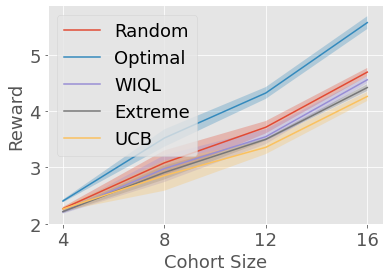

In [14]:
data = get_results_matching_parameters("baseline","hyperparameter",{'budget': 3})
plot_line_plot_parameter(data,'n_arms','mean_reward',method_to_nice)
plt.yticks([2,3,4,5])
plt.xticks([4,8,12,16])
sns.despine()
plt.legend()
plt.xlabel("Cohort Size")
plt.ylabel("Reward")
plt.savefig("../figures/baseline/reward_arms.pdf")


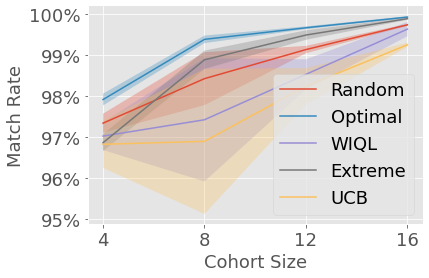

In [15]:
plot_line_plot_parameter(data,'n_arms','match_rate',match_to_nice)
plt.yticks([0.95,0.96,0.97,0.98,0.99,1.00],['95%','96%','97%','98%','99%','100%'])
plt.xticks([4,8,12,16])
sns.despine()
plt.legend()
plt.xlabel("Cohort Size")
plt.ylabel("Match Rate")
plt.savefig("../figures/baseline/match_arms.pdf")


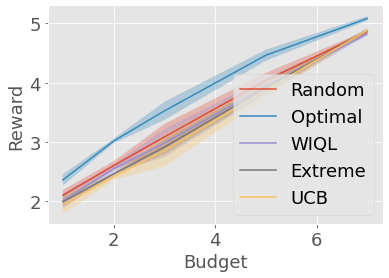

In [16]:
data = get_results_matching_parameters("baseline","hyperparameter",{'n_arms': 8})
plot_line_plot_parameter(data,'budget','mean_reward',method_to_nice)
plt.yticks([2,3,4,5])
plt.xticks([2,4,6])
sns.despine()
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Reward")
plt.savefig("../figures/baseline/reward_budget.pdf")


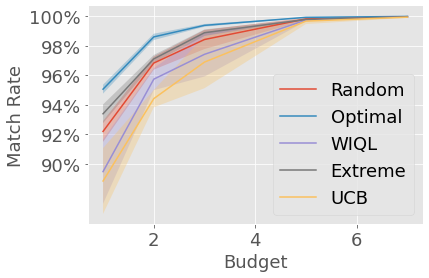

In [17]:
plot_line_plot_parameter(data,'budget','match_rate',match_to_nice)
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.00],['90%','92%','94%','96%','98%','100%'])
plt.xticks([2,4,6])
sns.despine()
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Match Rate")
plt.savefig("../figures/baseline/match_budget.pdf")

## Improving Bandits

In [18]:
data_synthetic = get_results_matching_parameters("replication","synthetic",{})
data_fr = get_results_matching_parameters("baseline","results",{'n_arms': 8, 'budget': 3})
data_better = get_results_matching_parameters("better_bandit","normal",{})

synthetic_data = []
fr_data = []

synthetic_data.append(np.mean([np.mean(i['mean_rewards']['ucw_ucb']) for i in data_synthetic]))
synthetic_data.append(np.mean([i['mean_reward_baseline'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])-synthetic_data[0])
synthetic_data.append(np.mean([i['mean_reward_norm'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])-(synthetic_data[1]+synthetic_data[0]))
synthetic_data_optimal = [np.mean([np.mean(i['mean_rewards']['optimal']) for i in data_synthetic])]
synthetic_data_random = [np.mean([np.mean(i['mean_rewards']['random']) for i in data_synthetic])]

fr_data.append(np.mean([i['mean_reward']['ucb_rewards'] for i in data_fr]))
fr_data.append(np.mean([i['mean_reward_baseline'] for i in data_better if i['parameters']['dataset'] == 'fr'])-fr_data[0])
fr_data.append(np.mean([i['mean_reward_norm'] for i in data_better if i['parameters']['dataset'] == 'fr'])-(fr_data[1]+fr_data[0]))
fr_data_optimal = np.mean([i['mean_reward']['optimal_rewards'] for i in data_fr])
fr_data_random = [np.mean([np.mean(i['mean_reward']['random_rewards']) for i in data_fr])]


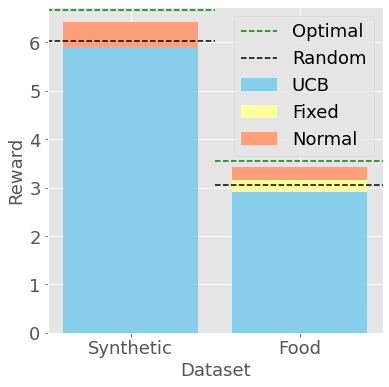

In [19]:
colors = ['#87CEEB', '#FFFF99', '#FFA07A']  # Pastel Blue, Yellow, and Red
labels = ['UCB','Fixed','Normal']


# Create a figure and axis
fig, ax = plt.subplots(figsize=(6,6))

# Create a stacked bar chart for the data
bottom = 0
for i, value in enumerate(synthetic_data):
    ax.bar(0, value, color=colors[i], bottom=bottom,label=labels[i])
    bottom += value

bottom = 0
for i, value in enumerate(fr_data):
    ax.bar(1, value, color=colors[i], bottom=bottom)
    bottom += value


# Customize labels and legend
ax.set_xticks([0,1])
ax.set_xticklabels(['Synthetic','Food'])
ax.set_xlabel('Dataset')
ax.set_ylabel('Reward')

ax.axhline(synthetic_data_optimal, color='green', linestyle='--',xmin=-0.5,xmax=0.5,label='Optimal')
ax.axhline(synthetic_data_random, color='black', linestyle='--',xmin=-0.5,xmax=0.5,label='Random')


ax.axhline(fr_data_optimal, color='green', linestyle='--',xmin=0.5,xmax=1.5)
ax.axhline(fr_data_random, color='black', linestyle='--',xmin=0.5,xmax=1.5)

plt.legend()
plt.savefig("../figures/better_bandit/normal_improvement.pdf")

## Matching Performance

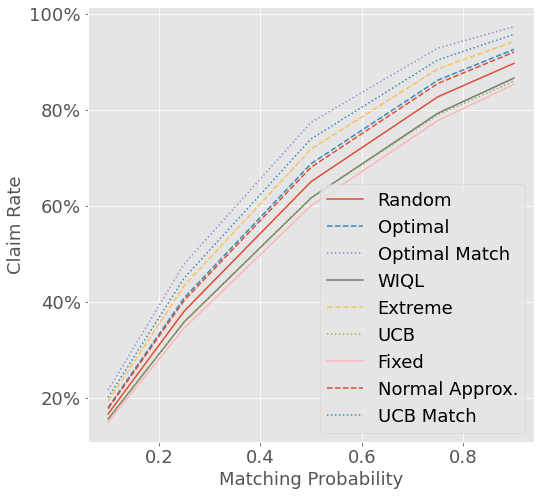

In [20]:
data_matching = get_results_matching_parameters("matching","p_val",{})
avg_reward_by_method = {}
all_p_vals = sorted(list(set([i['parameters']['match_prob'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for p in all_p_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['match_prob'] == p]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_p_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Matching Probability")
plt.ylabel("Claim Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.legend()

plt.savefig("../figures/matching/matching_p.pdf")

In [21]:
results = get_results_matching_parameters("matching","results",{})

mean_rewards = {}
active_rates = {}

for i in results:
    for j in i['mean_reward']:
        if j not in mean_rewards:
            mean_rewards[j] = []
        mean_rewards[j].append(i['mean_reward'][j])
    for j in i['active_rate']:
        if j not in active_rates:
            active_rates[j] = []
        active_rates[j].append(i['active_rate'][j])
for i in active_rates:
    active_rates[i] = np.mean(active_rates[i])
for i in mean_rewards:
    mean_rewards[i] = np.mean(mean_rewards[i])

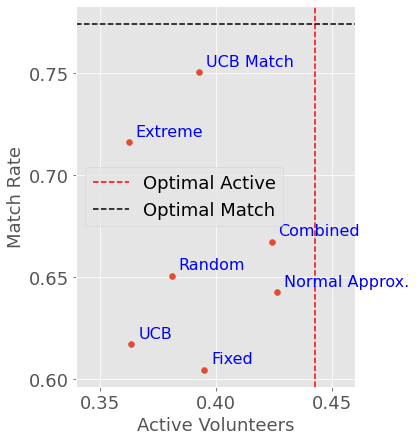

In [23]:
keys = active_rates.keys()
keys = [i for i in keys if 'optimal' not in i or 'predicted' in i] 
keys = [i for i in keys if 'wiql' not in i]
x = [active_rates[i] for i in keys]
y = [mean_rewards[i] for i in keys]

fig, ax = plt.subplots(figsize=(5,7))


plt.scatter(x,y)
y_line = mean_rewards['optimal_match_rewards']
x_line = active_rates['optimal_rewards']

ax.axvline(x=x_line, color='red', linestyle='--',label='Optimal Active')

# Plot the horizontal dashed line
ax.axhline(y=y_line, color='black', linestyle='--',label='Optimal Match')
plt.yticks([0.6,0.65,0.7,0.75])
plt.xticks([0.35,0.4,0.45])
plt.legend()

plt.ylabel("Match Rate")
plt.xlabel("Active Volunteers")

plt.xlim([0.34,0.46])
for name in keys:
    nice = method_to_nice[name]
    plt.text(active_rates[name] + 0.003, mean_rewards[name]+0.003, nice, fontsize=16
    , color='blue')
plt.savefig("../figures/matching/tradeoff.pdf")

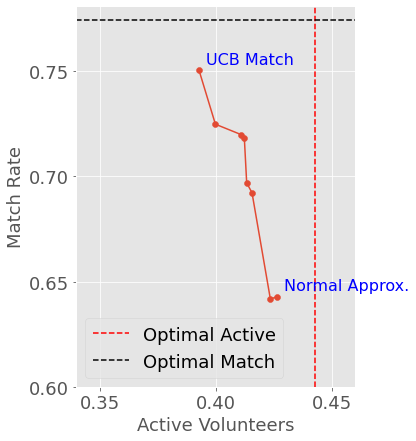

In [25]:
combined = get_results_matching_parameters("matching","combined_lamb",{})
pareto_data = []

for key in combined[0]['mean_reward'].keys():
    avg = []
    for data in combined:
        avg.append([data['active_rate'][key],data['mean_reward'][key]])
    avg = np.array(avg)
    avg = np.mean(avg,axis=0)
    pareto_data.append(avg)
pareto_data = filter_pareto_optimal(pareto_data)
pareto_data += [[x[i],y[i]] for i in range(len(x))]
pareto_data = sorted(pareto_data,key=lambda k: k[0])

keys = ['predicted_optimal_match_rewards','norm_rewards']
x = [active_rates[i] for i in keys]
y = [mean_rewards[i] for i in keys]

fig, ax = plt.subplots(figsize=(5,7))

plt.plot([i[0] for i in pareto_data],[i[1] for i in pareto_data])
plt.scatter([i[0] for i in pareto_data],[i[1] for i in pareto_data])

y_line = mean_rewards['optimal_match_rewards']
x_line = active_rates['optimal_rewards']

ax.axvline(x=x_line, color='red', linestyle='--',label='Optimal Active')

# Plot the horizontal dashed line
ax.axhline(y=y_line, color='black', linestyle='--',label='Optimal Match')
plt.yticks([0.6,0.65,0.7,0.75])
plt.xticks([0.35,0.4,0.45])
plt.legend()

plt.ylabel("Match Rate")
plt.xlabel("Active Volunteers")

plt.xlim([0.34,0.46])
for name in keys:
    nice = method_to_nice[name]
    plt.text(active_rates[name] + 0.003, mean_rewards[name]+0.003, nice, fontsize=16
    , color='blue')

plt.savefig("../figures/matching/tradeoff_pareto.pdf")